In this project, we are going to predict  house prices from a dataset provided by T81-558: Applications of Deep Neural Networks course by Washington University as part of course project. There are three datasets i.e. training set, test set and zipcodes. Zipcodes dataset has two features i.e. zipcodes and median income by zipcode.

Starting off with importing libraries 

In [43]:
import os
import pandas as pd
from scipy.stats import zscore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.stats import zscore

train = pd.read_csv("https://data.heatonresearch.com/data/t81-558/datasets/houses_train.csv")
test = pd.read_csv("https://data.heatonresearch.com/data/t81-558/datasets/houses_test.csv")
zips = pd.read_csv("https://data.heatonresearch.com/data/t81-558/datasets/zips.csv")


In [2]:
train.head()

,id,zip,bedrooms,bathrooms,garage,land,sqft,price
0,1,60019,9,2,3,2.198,4860,1005580
1,2,60049,5,2,2,4.517,2870,620278
2,3,60011,2,1,0,4.120,1220,265711
3,4,60027,6,4,2,3.201,3810,819916
4,5,60001,9,3,2,1.347,5061,1039491


In [3]:
test.head()

,id,zip,bedrooms,bathrooms,garage,land,sqft
0,10001,60027,8,6,2,2.901,5237
1,10002,60026,7,2,2,2.455,3929
2,10003,60036,2,1,0,4.213,1200
3,10004,60016,2,1,0,0.537,1152
4,10005,60044,3,1,1,3.014,1681


In [4]:
zips.head()

,zip,median_income
0,60000,75806
1,60001,205564
2,60002,307019
3,60003,145929
4,60004,135496


median_income is to be used as an input feature for our neural network. Hence, we need to merge it into both training and test datasets

In [5]:
train_data = pd.merge(train, zips, on='zip')
test_data = pd.merge(test, zips, on='zip')

In [8]:
x_columns = train_data.columns.drop(['id', 'zip', 'price'])
x = train_data[x_columns].values
y = train_data['price'].values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=1)

Defining and training the normalization layer to normalize all the numeric features that we have

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

Passing in the normalization layer that we defined earlier as first layer in our neural network. The network consists of three hidden layers and one output layer

In [11]:
model = Sequential([
                    normalizer,
                    Dense(6, activation='relu'),
                    #Dropout(0.5),
                    #Dense(10, activation='relu'),
                    #Dropout(0.5),
                    Dense(6, activation='relu'),
                    #Dropout(0.4),
                    #Dense(50, activation='relu'),
                    #Dropout(0.3),
                    Dense(6, activation='relu'),
                    #Dropout(0.2),
                    Dense(1)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 146
Trainable params: 133
Non-trainable params: 13
_________________________________________________________

Using mean_squared_error loss and root_mean_squared_error as evaluation metric as it is a regression problem and fitting the data on training set. The training stopped after 420 epochs with RMSE of 36 and validation loss of 228

In [13]:
model.compile(loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=0, mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor], verbose=1, epochs=1000)


Epoch 1/1000
250/250 [==============================] - 2s 5ms/step - loss: 486636552192.0000 - root_mean_squared_error: 697593.3750 - val_loss: 498479169536.0000 - val_root_mean_squared_error: 706030.5625
Epoch 2/1000
250/250 [==============================] - 1s 3ms/step - loss: 486545391616.0000 - root_mean_squared_error: 697528.0625 - val_loss: 498210177024.0000 - val_root_mean_squared_error: 705840.0625
Epoch 3/1000
250/250 [==============================] - 1s 3ms/step - loss: 485783994368.0000 - root_mean_squared_error: 696982.0625 - val_loss: 496704192512.0000 - val_root_mean_squared_error: 704772.4375
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 483191488512.0000 - root_mean_squared_error: 695119.7500 - val_loss: 492637519872.0000 - val_root_mean_squared_error: 701881.4375
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 477399973888.0000 - root_mean_squared_error: 690941.3750 - val_loss: 484493918208.0000 - val_root_me

Predicting the house prices for validation data and comparing it with actual prices. Our predictions are very close to the actual prices

In [14]:
preds = model.predict(X_test)
preds = preds.reshape(-1)
actual = y_test
results = pd.DataFrame(list(zip(actual, preds)),
               columns =['Actual price', 'Predicted price'])
results

,Actual price,Predicted price
0,390422,390418.40625
1,130534,130545.62500
2,257829,257824.78125
3,497184,497182.25000
4,607475,607474.93750
...,...,...
1995,155554,155552.00000
1996,351855,351855.37500
1997,957835,957837.75000
1998,582367,582366.93750


Plotting the actual and predicted prices and the graph shows that both are very close to eachother

Text(0.5, 1.0, 'Actual vs Predicted prices')

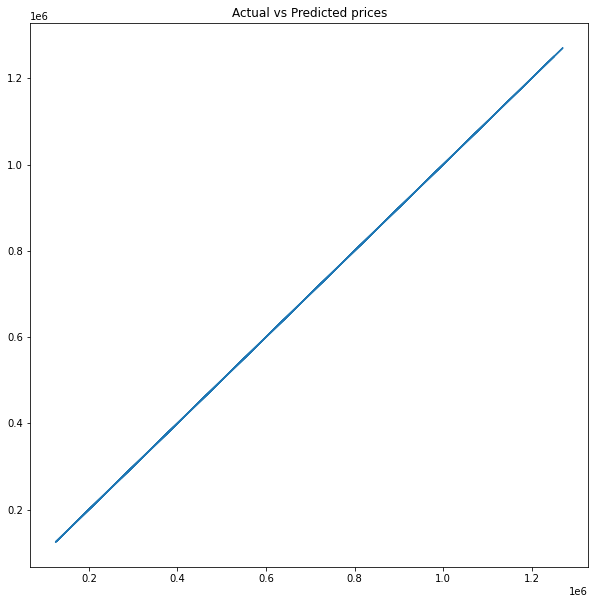

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(results['Actual price'], results['Predicted price']);
plt.title("Actual vs Predicted prices")

Preparing the test dataset for prediction by dropping id and zipcodes

In [17]:
test1 = test_data.drop(['id', 'zip'], axis=1)

The predicted prices for test dataset are saved in output DataFrame

In [38]:
np.set_printoptions(suppress=True)
preds = model.predict(test1).reshape(-1)
output = pd.DataFrame({'id': test_data.id,
                       'Price' : preds})
pd.options.display.float_format = '{:.4f}'.format
output

,id,Price
0,10001,1103811.7500
1,10014,388244.2500
2,10057,271600.6875
3,10142,946556.8750
4,10205,277020.9688
...,...,...
1995,11665,1019223.9375
1996,11800,796296.3750
1997,11819,500423.7812
1998,11847,357201.0312
